In [43]:
from load_data import load_clients
import phonenumbers
import pycountry
import re
from sklearn.metrics import confusion_matrix
import numpy as np
from datetime import datetime
from countryinfo import CountryInfo
from email_validator import validate_email, EmailNotValidError
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderUnavailable, GeocoderTimedOut
import pgeocode
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from xgboost import XGBClassifier
import numpy as np
from datetime import timedelta


from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from BorutaShap import BorutaShap


In [ ]:
# !pip install git+https://github.com/Ekeany/Boruta-Shap.git


  Cloning https://github.com/Ekeany/Boruta-Shap.git to c:\users\aliak\appdata\local\temp\pip-req-build-9208drgq
  Resolved https://github.com/Ekeany/Boruta-Shap.git to commit 3f7d60f78ff05b8da015339e9188980a18456a5e
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for BorutaShap: filename=BorutaShap-1.0.14-py3-none-any.whl size=14954 sha256=307c062d710c69868ce98d8f58a99f47ff170d4b3023d04cef6fd32d143d48a8
  Stored in directory: C:\Users\aliak\AppData\Local\Temp\pip-ephem-wheel-cache-5cq1tahd\wheels\3d\da\1c\85c55fc0c6b773c4a9481843be489679f0fea20cf99d486230
Successfully built BorutaShap


  Running command git clone --filter=blob:none --quiet https://github.com/Ekeany/Boruta-Shap.git 'C:\Users\aliak\AppData\Local\Temp\pip-req-build-9208drgq'


In [3]:
clients = load_clients("clients.pkl")

In [4]:
print(clients[0])

{'passport': {'first_name': 'Freja', 'middle_name': 'Katrine', 'last_name': 'Christensen', 'gender': 'F', 'country': 'Denmark', 'country_code': 'DNK', 'nationality': 'Danish', 'birth_date': '2002-04-18', 'passport_number': 'UE2130779', 'passport_mrz': ['P<DNKCHRISTENSEN<<FREJA<KATRINE<<<<<<<<<<<<<<', 'UE2130779DNK020418<<<<<<<<<<<<<<<<<<<<<<<<<<<'], 'passport_issue_date': '2017-05-11', 'passport_expiry_date': '2027-05-10'}, 'client_profile': {'name': 'Freja Katrine Christensen', 'address': {'city': 'Aalborg', 'street name': 'Strøget', 'street number': 57, 'postal code': '2044'}, 'country_of_domicile': 'Denmark', 'birth_date': '2002-04-18', 'nationality': 'Danish', 'passport_number': 'UE2130779', 'passport_issue_date': '2017-05-11', 'passport_expiry_date': '2027-05-10', 'gender': 'F', 'phone_number': '53 11 20 42', 'email_address': 'freja.christensen@yousee.dk', 'marital_status': 'single', 'secondary_school': {'name': 'Holstebro Gymnasium', 'graduation_year': 2022}, 'higher_education': 

# 3- Define check functions

In [5]:
error_messages = ['High School Graduation Inconsistent', 'Inconsistent country code, country name or nationality', 'Invalid Phone Number', 'Invalid Postal Code']

In [6]:
def is_high_school_graduation_year_valid(graduation_year: int, birth_date: str, min_age: int = 16, max_age: int = 21) -> bool:
    """
    Check if the graduation year is reasonable given a person's birth date.

    Args:
        graduation_year (int): The year the person graduated high school.
        birth_date (str): Birth date in "YYYY-MM-DD" format.
        min_age (int): Minimum expected age at graduation (default: 16)
        max_age (int): Maximum expected age at graduation (default: 23)

    Returns:
        bool: True if the graduation year is within a reasonable age range.
    """
    try:
        birth_year = datetime.strptime(birth_date, "%Y-%m-%d").year
        age_at_graduation = graduation_year - birth_year
        return min_age <= age_at_graduation <= max_age
    except ValueError:
        print("Invalid birth date format. Use YYYY-MM-DD.")
        return False

In [7]:
def check_multiple_country_consistency(codes_str, countries_str, nationalities_str):
    # Split input strings by commas and strip whitespace
    codes = [c.strip() for c in codes_str.split(',')]
    countries = [c.strip() for c in countries_str.split(',')]
    nationalities = [n.strip() for n in nationalities_str.split(',')]

    # Ensure all lists have the same length
    if not (len(codes) == len(countries) == len(nationalities)):
        return False, "Input lists must be of the same length"

    results = []

    for i, (code, country_name, nationality) in enumerate(zip(codes, countries, nationalities)):
        try:
            # 1. Validate country code
            country = pycountry.countries.get(alpha_2=code.upper())
            if not country:
                results.append((False, f"[{i}] Invalid country code: {code}"))
                continue

            # 2. Check if country name matches code
            if country.name.lower() != country_name.lower():
                results.append((False, f"[{i}] Mismatch: code '{code}' is for '{country.name}', not '{country_name}'"))
                continue

            # 3. Check nationality using CountryInfo
            info = CountryInfo(country.name)
            expected_nationality = info.info().get("demonym", None)

            if not expected_nationality:
                results.append((False, f"[{i}] Could not find nationality for '{country.name}'"))
                continue

            if nationality.lower() != expected_nationality.lower():
                results.append((False, f"[{i}] Nationality '{nationality}' does not match expected '{expected_nationality}' for {country.name}"))
                continue

            # All good for this triplet
            results.append((True, f"[{i}] All fields are consistent and valid"))

        except KeyError:
            results.append((False, f"[{i}] CountryInfo does not recognize '{country_name}'"))
        except Exception as e:
            results.append((False, f"[{i}] Error: {str(e)}"))

    return results

In [8]:
def could_be_valid_email(email):
    try:
        validate_email(email, check_deliverability=False)
        return True
    except EmailNotValidError:
        return False

def compare_strings_ignore_spaces(str1, str2):
    clean1 = str1.replace(" ", "")
    clean2 = str2.replace(" ", "")
    return clean1 == clean2

def william_flags(client):
    flags = True
    if client['passport']['first_name'] != client['account_form']['first_name']:
        flags = False
    if client['passport']['last_name'] != client['account_form']['last_name']:
        flags = False
    if client['passport']['middle_name'] != client['account_form']['middle_name']:
        flags = False
    if compare_strings_ignore_spaces((client['passport']['first_name']+client['passport']['middle_name']+client['passport']['last_name']), client['account_form']['name']) == False:
        flags = False
    if compare_strings_ignore_spaces((client['passport']['first_name']+client['passport']['middle_name']+client['passport']['last_name']), client['client_profile']['name']) == False:
        flags = False
    if client['passport']['gender'] != client['client_profile']['gender']:
        flags = False

    if client['passport']['passport_number'] != client['account_form']['passport_number']:
        flags = False
    
    # Convert string to datetime object (adjust format if needed)
    expiry_date = datetime.strptime(client['passport']['passport_expiry_date'], "%Y-%m-%d").date()
    today = datetime.strptime("2021-04-10", "%Y-%m-%d").date() #2025-04-1  ?
    if expiry_date < today:
        flags = False
    
    if could_be_valid_email(client['client_profile']['email_address']) == False:
        flags = False
    if client['account_form']['email_address'] != client['client_profile']['email_address']:
        flags = False   
    if client['account_form']['phone_number'] != client['client_profile']['phone_number']:
        flags = False 
    passport_birth_date = datetime.strptime(client['passport']['birth_date'], "%Y-%m-%d").date()
    client_birth_date = datetime.strptime(client['client_profile']['birth_date'], "%Y-%m-%d").date()
    passport_issued_date = datetime.strptime(client['passport']['passport_issue_date'], "%Y-%m-%d").date()
    client_issued_date = datetime.strptime(client['client_profile']['passport_issue_date'], "%Y-%m-%d").date()
    passport_expiry_date = datetime.strptime(client['passport']['passport_expiry_date'], "%Y-%m-%d").date()
    client_expiry_date = datetime.strptime(client['client_profile']['passport_expiry_date'], "%Y-%m-%d").date()
    if passport_expiry_date < passport_issued_date:
        flags = False
    if passport_birth_date != client_birth_date:
        flags = False
    if passport_issued_date != client_issued_date:
        flags = False
    if passport_expiry_date != client_expiry_date:
        flags = False
    if passport_issued_date < passport_birth_date:
        flags = False
    return flags

In [9]:
def mrz_check(client):
    flags = True
    if (flags == True) and (client['passport']['last_name'].upper() not in client['passport']['passport_mrz'][0] or client['passport']['first_name'].upper() not in client['passport']['passport_mrz'][0] or client['passport']['middle_name'].upper() not in client['passport']['passport_mrz'][0] or client['passport']['country_code'].upper() not in client['passport']['passport_mrz'][0]):
        flags = False
    if (flags == True) and ((len(client['passport']['middle_name']) == 0) and not (client['passport']['passport_mrz'][0].index(client['passport']['country_code'].upper()) < client['passport']['passport_mrz'][0].index(client['passport']['last_name'].upper()))): #no middle name
        flags = False
    if (flags == True) and ((len(client['passport']['middle_name']) != 0) and not (client['passport']['passport_mrz'][0].index(client['passport']['country_code'].upper()) < client['passport']['passport_mrz'][0].index(client['passport']['last_name'].upper()) < client['passport']['passport_mrz'][0].index(client['passport']['middle_name'].upper()))):
        flags = False
    if (flags == True) and (client['passport']['passport_number']+client['passport']['country_code']+client['passport']['birth_date'].replace('-','')[2:] not in client['passport']['passport_mrz'][1]):
        flags = False
    return flags

In [10]:
def currency_match(client):
    flags = True
    if client['account_form']['currency'] != client['client_profile']['currency']:
        flags = False
    return flags

In [11]:
def domicile_validator(client):
    """
    Validates if the country of domicile in client profile corresponds to the country of domicile in account form
    """
    return client['account_form']['country_of_domicile'] == client['client_profile']['country_of_domicile']

def address_validator(client):
    """
    Validates if the address in client profile corresponds to the address in account form
    """
    return client['account_form']['address'] == client['client_profile']['address']

_nomi_cache = {}

def get_country_code(country_name):
    """
    Convert a full country name (e.g., 'Spain') to ISO Alpha-2 code (e.g., 'ES').

    Returns:
        str or None: ISO Alpha-2 code or None if not found.
    """
    try:
        return pycountry.countries.lookup(country_name).alpha_2
    except LookupError:
        return None

def get_nomi_instance(country_code):
    """
    Return a cached pgeocode.Nominatim instance for the given country.
    """
    if country_code not in _nomi_cache:
        _nomi_cache[country_code] = pgeocode.Nominatim(country_code)
    return _nomi_cache[country_code]

def validate_postal_code_for_client(client):
    """
    Validates if the postal code exists in the provided city and country.

    Parameters:
        client (dict): a client info.

    Returns:
        bool: True if postal code matches the city in any listed country, else False.
    """

    # client_profile (dict): Must include 'address' and 'country_of_domicile'.
    client_profile = client['client_profile']
    country_names = [name.strip() for name in client_profile.get('country_of_domicile', '').split(',')]
    address = client_profile.get('address', {})
    city = address.get('city', '').lower()
    postal_code = address.get('postal code', '')

    for country_name in country_names:
        country_code = get_country_code(country_name)
        if not country_code:
            continue  # Skip invalid countries

        nomi = get_nomi_instance(country_code)
        postal_info = nomi.query_postal_code(postal_code)['postal_code']

        if postal_info is None:
            continue

        # matched_cities = [c.strip().lower() for c in postal_info.place_name.split(',')]
        if postal_info == postal_code:
            return True  # Valid match

    return False  # No match found


In [12]:
def check_age(client):
    try:
        birth_date = datetime.strptime(client['client_profile']['birth_date'], "%Y-%m-%d")
        age = (datetime.now()-timedelta(5) - birth_date).days // 365
        return age >=18
    except ValueError:
        print("Invalid date format. Use YYYY-MM-DD.")
        return None

In [13]:
def check_higher_education(client):
    try:
        if client['client_profile']['higher_education'] is None or len(client['client_profile']['higher_education']) == 0:
            return True
        else:
            birth_date = datetime.strptime(client['client_profile']['birth_date'], "%Y-%m-%d")
            if client['client_profile']['higher_education'][0]['graduation_year'] > client['client_profile']['secondary_school']['graduation_year'] and client['client_profile']['higher_education'][0]['graduation_year'] - int(birth_date.year) >17:
                return True
            else:
                return False
    except ValueError:
        print("Invalid date format. Use YYYY-MM-DD.")
        return False

In [14]:
def check_employment_history(client):
    try:
        if client['client_profile']['employment_history'] is None or len(client['client_profile']['employment_history']) == 0:
            return True
        else:
            birth_date = datetime.strptime(client['client_profile']['birth_date'], "%Y-%m-%d")
            if client['client_profile']['employment_history'][0]['start_year']  - int(birth_date.year) >16:
                return True
            else:
                return False
    except ValueError:
        print("Invalid date format. Use YYYY-MM-DD.")
        return False

In [15]:
def check_gender_not_null(client):
    if client["passport"]["gender"] is None or client["passport"]["gender"] == "":
        return False
    return True

def check_mandate_not_null(client):
    if client["client_profile"]["type_of_mandate"] is None or client["client_profile"]["type_of_mandate"] == "":
        return False
    return True

In [16]:
def check_empty_risk_profile(client):
    if client["client_profile"]["investment_risk_profile"] is None or client["client_profile"]["investment_risk_profile"] == "":
        return False
    return True

In [17]:
def check_properties_sum_to_aum(client):
    try:
        if client["client_profile"]["real_estate_details"] is None or len(client["client_profile"]["real_estate_details"]) == 0 and client["client_profile"]["aum"]["real_estate_value"]>0:
            return False
        else:
            value = [prop["property value"] for prop in client["client_profile"]["real_estate_details"]]
            value = sum(value)
            if value == client["client_profile"]["aum"]["real_estate_value"]:
                return True
            else:
                return False
    except ValueError:
        print("Invalid date format. Use YYYY-MM-DD.")
        return False

# 4- Flag the dataset

In [18]:
flags_preds = []

for client in clients:
    flags = True
    if not check_multiple_country_consistency(client["passport"]["country_code"],client["passport"]["country"],client["passport"]["nationality"]) or not is_high_school_graduation_year_valid(client['client_profile']['secondary_school']['graduation_year'], client['client_profile']['birth_date']) or not validate_postal_code_for_client(client) or not domicile_validator(client) or not address_validator(client) or not currency_match(client) or not mrz_check(client) or not william_flags(client) or not check_age(client) or not check_higher_education(client) or not check_employment_history(client) or not check_gender_not_null(client) or not check_empty_risk_profile(client) or not check_properties_sum_to_aum(client):
        flags = False
    flags_preds.append(flags)

In [19]:
client_labels = []
for client in clients:
    if client['label']['label'] == 'Reject':
        client_labels.append(False)
    elif client['label']['label'] == 'Accept':
        client_labels.append(True)

# 5- Reducing training to mistakes

In [20]:
remaining_indexes = []
for i in range(len(flags_preds)):
    if flags_preds[i] != client_labels[i] or client_labels[i] == flags_preds[i] == True:
        remaining_indexes.append(i)
print("Remaining indexes length: ", len(remaining_indexes))

Remaining indexes length:  6404


In [21]:
#Only select the wrong indexes
remaining_clients = [clients[j] for j in remaining_indexes]

In [22]:
#save the remaining clients to a new file
import pickle
with open("remaining_clients.pkl", "wb") as f:
    pickle.dump(remaining_clients, f)

#### 5.5 Adding more flags

In [66]:
client_labels1 = []
for clients in remaining_clients:
    if clients['label']['label'] == 'Reject':
        client_labels1.append(False)
    elif clients['label']['label'] == 'Accept':
        client_labels1.append(True)

def check_client_labels(clients, flags):
    if clients['label']['label'] == 'Reject' and flags == False:
        return 1
    elif clients['label']['label'] == 'Accept' and flags == True:
        return 1
    elif clients['label']['label'] == 'Accept' and flags == False:
        print("false negative")
        return 0
    return 0

flags_preds1 = []       
for client in remaining_clients:
    flags = True

    # inheritance details missing
    if client['client_profile']['aum']['inheritance'] != 0:
        for key, value in client['client_profile']['inheritance_details'].items():
            if value == '':
                flags = False

    # passport number missing in client_profile
    if client['client_profile']['passport_number'] is None or client['client_profile']['passport_number'] == '':
        flags = False

    # phone number missing in client_profile
    if client['client_profile']['phone_number'] is None or client['client_profile']['phone_number'] == '':
        flags = False

    # any address info missing in client_profile
    for key, value in client['client_profile']['address'].items():
        if value is None or value == '':
            flags = False

    # any employment history missing in client_profile
    if client['client_profile']['employment_history'] != []:
        for job in client['client_profile']['employment_history']:
            for key, value in job.items():
                if value == '':
                    flags = False

    # education background missing in client_profile (should be the check for any note missing in client_description from my point of view)
    if client['client_description']['Education Background'] == '':
        flags = False

    # any info except middle name is missing in passport info
    for key, value in client['passport'].items():
        if key != 'middle_name' and value == '':   
            flags = False

    # any info except middle name and address is missing in account_form
    for key, value in client['account_form'].items():
        if key != 'address' and key != 'middle_name' and value == '':   
            flags = False

    # any address info missing in account_form
    for key, value in client['account_form']['address'].items():
        if value is None or value == '':
            flags = False

    

    flags_preds1.append(flags)


In [67]:
remaining_indexes1 = []
for i in range(len(flags_preds1)):
    if flags_preds1[i] != client_labels1[i] or client_labels1[i] == flags_preds1[i] == True:
        remaining_indexes1.append(i)
print("Remaining indexes length: ", len(remaining_indexes1))

Remaining indexes length:  6285


In [68]:
remaining_clients1 = [remaining_clients[j] for j in remaining_indexes1]

In [69]:
#save the remaining clients to a new file
import pickle
with open("remaining_clients1.pkl", "wb") as f:
    pickle.dump(remaining_clients1, f)

In [72]:
# sanity check
removed_clients = [i for i in remaining_clients if i not in remaining_clients1]
len(removed_clients)

119

In [74]:
for client in removed_clients:
    if client['label']['label'] != 'Reject':
        print(client)

# 6- Encode Data

In [75]:
import pickle
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from load_updated_data import load_clients
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
from typing import List, Dict, Any, Tuple



def data_to_df(full_data:list):
    dfs = []
    for client in full_data:
        keep = [
            ['gender', 'country_code', 'birth_date'],
            ['country_of_domicile', 'nationality', 'marital_status','real_estate_details', 'investment_risk_profile',
             'higher_education', 'employment_history', 'investment_risk_profile', 'investment_horizon', 'investment_experience',
             'type_of_mandate', 'preferred_markets', 'currency'],
            [],
            [],
            ['label']
                ]
        keys=client.keys()
        res={}
        for key, subkeys in zip(keys, keep):
            d = {subkey: client[key][subkey] for subkey in subkeys }
            res = res|d
        #Convert label to 1 or 0 if accepted or rejected
        if res['label']== 'Reject':
            res['label'] = 0
        elif res['label'] == 'Accept':
            res['label'] = 1
        dfs.append(res)
        
        
    return pd.DataFrame.from_records(dfs)



country_code_encoder = LabelEncoder()
country_dom_encoder = LabelEncoder()
marital_status_encoder = LabelEncoder()
investment_experience_encoder = LabelEncoder()
currency_encoder = LabelEncoder()
gender_encoder = LabelEncoder()
nationality_encoder = LabelEncoder()
irp_encoder = LabelEncoder()
ih_encoder = LabelEncoder()
mandate_encoder = LabelEncoder()
pref_markets_encoder=MultiLabelBinarizer()

def encode_gender(df:pd.DataFrame,encoder:LabelEncoder)-> pd.DataFrame:
    encoder.fit(df['gender'])
    df['gender'] = encoder.transform(df['gender'])
    return df

def encode_nationality(df:pd.DataFrame,encoder:LabelEncoder)-> pd.DataFrame:
    encoder.fit(df['nationality'])
    df['nationality'] = encoder.transform(df['nationality'])
    return df

def encode_irp(df:pd.DataFrame,encoder:LabelEncoder)-> pd.DataFrame:
    encoder.fit(df['investment_risk_profile'])
    df['investment_risk_profile'] = encoder.transform(df['investment_risk_profile'])
    return df

def encode_ih(df:pd.DataFrame,encoder:LabelEncoder)-> pd.DataFrame:
    encoder.fit(df['investment_horizon'])
    df['investment_horizon'] = encoder.transform(df['investment_horizon'])
    return df

def encode_mandate(df:pd.DataFrame,encoder:LabelEncoder)-> pd.DataFrame:
    encoder.fit(df['type_of_mandate'])
    df['type_of_mandate'] = encoder.transform(df['type_of_mandate'])
    return df

def encode_pref_markets(df:pd.DataFrame,encoder:MultiLabelBinarizer)-> pd.DataFrame:
    encoded=encoder.fit_transform(df['preferred_markets'].to_list())
    temp_df = pd.DataFrame.from_records(encoded)
    temp_df.rename(columns = {i: f'pref_markets_{i}' for i in range(temp_df.shape[1])},inplace=True)
    return pd.concat([df,temp_df],axis=1)

def encode_country_code(df: pd.DataFrame,encoder:LabelEncoder) -> pd.DataFrame:
    encoder.fit(df['country_code'])
    df['country_code'] = encoder.transform(df['country_code'])
    return df

def get_age(birth_date: str) -> int:
    try:
        birth_date = datetime.strptime(birth_date, "%Y-%m-%d")
        age = (datetime.now()-timedelta(5) - birth_date).days // 365
        return age
    except ValueError:
        print("Invalid date format. Use YYYY-MM-DD.")
        return None

def encode_age(df: pd.DataFrame) -> pd.DataFrame:
    df['age'] = df['birth_date'].apply(get_age)
    return df

def encode_country_of_domicile(df: pd.DataFrame,encoder:LabelEncoder) -> pd.DataFrame:
    encoder.fit(df['country_of_domicile'])
    df['country_of_domicile'] = encoder.transform(df['country_of_domicile'])
    return df

def encode_marital_status(df: pd.DataFrame,encoder:LabelEncoder) -> pd.DataFrame:
    encoder.fit(df['marital_status'])
    df['marital_status'] = encoder.transform(df['marital_status'])
    return df

def encode_investment_experience(df: pd.DataFrame,encoder:LabelEncoder) -> pd.DataFrame:
    encoder.fit(df['investment_experience'])
    df['investment_experience'] = encoder.transform(df['investment_experience'])
    return df

def encode_currency(df: pd.DataFrame,encoder:LabelEncoder) -> pd.DataFrame:
    encoder.fit(df['currency'])
    df['currency'] = encoder.transform(df['currency'])
    return df

def get_higher_ed(higher_ed: list) -> int:
    if higher_ed is None or len(higher_ed) == 0:
        return 0
    else:
        return 1

def encode_higher_education(df: pd.DataFrame) -> pd.DataFrame:
    df['higher_education'] = df['higher_education'].apply(get_higher_ed)
    return df

def encode(x:pd.DataFrame)-> pd.DataFrame:
    x= encode_gender(x,gender_encoder)
    x = encode_nationality(x,nationality_encoder)
    x = encode_irp(x,irp_encoder)
    x = encode_ih(x, ih_encoder)
    x = encode_mandate(x,mandate_encoder)
    x = encode_pref_markets(x, pref_markets_encoder)
    x = encode_country_code(x,country_code_encoder)
    x = encode_age(x)
    x = encode_country_of_domicile(x,country_dom_encoder)
    x = encode_marital_status(x,marital_status_encoder)
    x = encode_investment_experience(x, investment_experience_encoder)
    x = encode_currency(x,currency_encoder)
    x = encode_higher_education(x)
    return x


def calculate_effective_experience(jobs: List[Tuple[int, int]]) -> int:
    """
    Calculates effective work experience in years, avoiding double-counting overlapping years.

    Args:
        jobs: List of (start_year, end_year) tuples. None as end_year means the job is current.

    Returns:
        Total number of unique working years across all jobs.
    """
    worked_years = set()
    for start, end in jobs:
        if start is None:
            continue
        end = end if end is not None else 2025
        worked_years.update(range(start, end))
    return len(worked_years)

def extract_numeric_features(full_data: List[Dict[str, Any]]) -> pd.DataFrame:
    """
    Extracts numeric features from a list of client dictionaries.

    Args:
        full_data: List of dictionaries, each representing a client with nested data.

    Returns:
        A pandas DataFrame containing engineered numeric features.
    """

    aum_vec = [np.sum(list(client['client_profile']['aum'].values())) for client in full_data]
    property_value_vec = [client['client_profile']['aum']['real_estate_value'] for client in full_data]
    property_count_vec = [len(client['client_profile']['real_estate_details']) for client in full_data]
    inheritance_vec = [client['client_profile']['aum']['inheritance'] for client in full_data]
    savings_vec = [client['client_profile']['aum']['savings'] for client in full_data]
    job_count_vec = [len(client['client_profile']['employment_history']) for client in full_data]

    # Compute property-to-cash ratio with zero-division handling
    property_to_cash_vec = [
        prop_value / (total_value - prop_value) if (total_value - prop_value) != 0 else -float('inf')
        for prop_value, total_value in zip(property_value_vec, aum_vec)
    ]
    max_ratio = np.max(property_to_cash_vec)
    property_to_cash_vec = [max_ratio if value == -float("inf") else value for value in property_to_cash_vec]

    # Inheritance / (inheritance + savings), safe against zero-division
    inheritance_to_cash_vec = [
        inheritance / (inheritance + saving) if (inheritance + saving) != 0 else 0
        for inheritance, saving in zip(inheritance_vec, savings_vec)
    ]

    # Salary & experience metrics
    current_salary_vec = []
    max_salary_vec = []
    total_work_experience_vec = []
    effective_work_experience_vec = []

    for client in full_data:
        emp_hist = client['client_profile']['employment_history']
        salary = 0
        max_salary = 0

        if len(emp_hist) == 0:
            total_work_experience = 0
            effective_work_experience = 0

        else:
            year_history = []
            min_start = np.inf
            max_end = -np.inf
            for job in emp_hist:
                if max_salary < job['salary']:
                    max_salary = job['salary']

                start, end = job['start_year'], job['end_year']
                year_history.append((start, end))

                if end is None:
                    salary += job['salary']
                    end = 2025

                if start < min_start:
                    min_start = start
                if end > max_end:
                    max_end = end

            total_work_experience = max_end - min_start
            effective_work_experience = calculate_effective_experience(year_history)

        total_work_experience_vec.append(total_work_experience)
        effective_work_experience_vec.append(effective_work_experience)
        current_salary_vec.append(salary)
        max_salary_vec.append(max_salary)

    # Savings per active work year
    saving_per_annum_vec = [
        saving / work_exp if work_exp != 0 else saving
        for saving, work_exp in zip(savings_vec, effective_work_experience_vec)
    ]

    # Current salary compared to max salary seen in career
    salary_to_max_salary_vec = [
        salary / max_salary if max_salary != 0 else 0
        for salary, max_salary in zip(current_salary_vec, max_salary_vec)
    ]

    # Construct final DataFrame
    df_numeric = pd.DataFrame({
        'aum': aum_vec,
        'property_value': property_value_vec,
        'num_properties': property_count_vec,
        'inheritance_value': inheritance_vec,
        'savings_value': savings_vec,
        'num_jobs': job_count_vec,
        'current_salary': current_salary_vec,
        'max_salary': max_salary_vec,
        'property_to_cash_ratio': property_to_cash_vec,
        'inheritance_to_cash_ratio': inheritance_to_cash_vec,
        'total_work_experience': total_work_experience_vec,
        'effective_work_experience': effective_work_experience_vec,
        'saving_per_annum': saving_per_annum_vec,
        'salary_to_max_salary_ratio': salary_to_max_salary_vec
    })

    return df_numeric

def data_for_ML(data:list) -> pd.DataFrame:
    x = extract_numeric_features(data)
    y = encode(data_to_df(data))
    return pd.concat([y,x],axis=1)

In [76]:
remaining_clients = load_clients("remaining_clients1.pkl")
remaining_clients_df = data_for_ML(remaining_clients)

In [115]:
# 0 - CHF, 1 - DKK, 2 - EUR
chf_to_eur = 1.06
dkk_to_eur = 0.134

money_features = ['aum', 'property_value', 'inheritance_value', 'savings_value', 'current_salary', 'max_salary', 'saving_per_annum']
remaining_clients_df.loc[remaining_clients_df['currency'] == 0, money_features] *= chf_to_eur
remaining_clients_df.loc[remaining_clients_df['currency'] == 1, money_features] *= dkk_to_eur

In [107]:
remaining_clients_df[['age', 'aum', 'property_value', 'num_properties',
       'inheritance_value', 'savings_value', 'num_jobs', 'current_salary',
       'max_salary', 'property_to_cash_ratio', 'inheritance_to_cash_ratio',
       'total_work_experience', 'effective_work_experience',
       'saving_per_annum', 'salary_to_max_salary_ratio']].head()

,age,aum,property_value,num_properties,inheritance_value,savings_value,num_jobs,current_salary,max_salary,property_to_cash_ratio,inheritance_to_cash_ratio,total_work_experience,effective_work_experience,saving_per_annum,salary_to_max_salary_ratio
0,22,13140000,0,0,13140000,0,0,0,0,0.000000,1.000000,0,0,0.000000,0.0
1,27,2440000,0,0,2420000,20000,1,45000,45000,0.000000,0.991803,3,3,6666.666667,1.0
2,27,1370000,0,0,1350000,20000,1,43000,43000,0.000000,0.985401,3,3,6666.666667,1.0
3,59,6965000,2825000,2,2690000,1450000,5,821000,821000,0.682367,0.649758,35,29,50000.000000,1.0
4,58,4050000,1790000,1,670000,1590000,5,929000,929000,0.792035,0.296460,34,31,51290.322581,1.0


In [127]:
remaining_clients_df.columns

Index(['gender', 'country_code', 'birth_date', 'country_of_domicile',
       'nationality', 'marital_status', 'real_estate_details',
       'investment_risk_profile', 'higher_education', 'employment_history',
       'investment_horizon', 'investment_experience', 'type_of_mandate',
       'preferred_markets', 'currency', 'label', 'pref_markets_0',
       'pref_markets_1', 'pref_markets_2', 'pref_markets_3', 'pref_markets_4',
       'pref_markets_5', 'pref_markets_6', 'pref_markets_7', 'pref_markets_8',
       'pref_markets_9', 'age', 'aum', 'property_value', 'num_properties',
       'inheritance_value', 'savings_value', 'num_jobs', 'current_salary',
       'max_salary', 'property_to_cash_ratio', 'inheritance_to_cash_ratio',
       'total_work_experience', 'effective_work_experience',
       'saving_per_annum', 'salary_to_max_salary_ratio'],
      dtype='object')

In [129]:
remaining_clients_df['label']

0       1
1       0
2       1
3       1
4       0
       ..
6280    1
6281    1
6282    1
6283    0
6284    1
Name: label, Length: 6285, dtype: int64

<AxesSubplot:xlabel='salary_to_max_salary_ratio', ylabel='Density'>

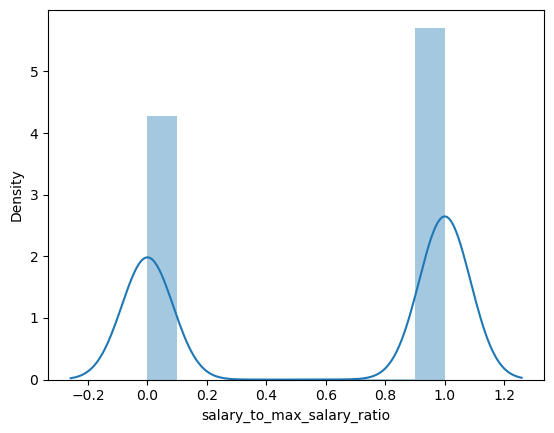

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(remaining_clients_df['salary_to_max_salary_ratio'])

In [79]:
np.sum(remaining_clients_df['salary_to_max_salary_ratio'] == 1)

3579

In [80]:
np.sum(remaining_clients_df['salary_to_max_salary_ratio'] == 0)

2688

In [81]:
2688+3579, remaining_clients_df.shape

(6267, (6285, 41))

In [34]:
remaining_clients_df.loc[1, 'employment_history']

[{'start_year': 2022,
  'end_year': None,
  'company': 'Bayerische Staatsgemäldesammlungen',
  'position': 'Art Dealer',
  'salary': 45000}]

In [35]:
remaining_clients_df.loc[2, 'employment_history']

[{'start_year': 2022,
  'end_year': None,
  'company': 'Van Gogh Museum',
  'position': 'Art Dealer',
  'salary': 43000}]

In [82]:
remaining_clients_df.columns

Index(['gender', 'country_code', 'birth_date', 'country_of_domicile',
       'nationality', 'marital_status', 'real_estate_details',
       'investment_risk_profile', 'higher_education', 'employment_history',
       'investment_horizon', 'investment_experience', 'type_of_mandate',
       'preferred_markets', 'currency', 'label', 'pref_markets_0',
       'pref_markets_1', 'pref_markets_2', 'pref_markets_3', 'pref_markets_4',
       'pref_markets_5', 'pref_markets_6', 'pref_markets_7', 'pref_markets_8',
       'pref_markets_9', 'age', 'aum', 'property_value', 'num_properties',
       'inheritance_value', 'savings_value', 'num_jobs', 'current_salary',
       'max_salary', 'property_to_cash_ratio', 'inheritance_to_cash_ratio',
       'total_work_experience', 'effective_work_experience',
       'saving_per_annum', 'salary_to_max_salary_ratio'],
      dtype='object')

# 7- Training function

In [116]:
features = ['gender', 'country_code', 'age', 'country_of_domicile',
       'nationality', 'marital_status', 'higher_education',
       'investment_risk_profile', 'investment_horizon',
       'investment_experience', 'type_of_mandate',
       'currency', 'pref_markets_0', 'pref_markets_1',
       'pref_markets_2', 'pref_markets_3', 'pref_markets_4', 'pref_markets_5',
       'pref_markets_6', 'pref_markets_7', 'pref_markets_8', 'pref_markets_9',
        'aum', 'property_value', 'num_properties', 
       'savings_value', 'num_jobs', 'current_salary',
       'property_to_cash_ratio', 'inheritance_to_cash_ratio',
       'total_work_experience', 'effective_work_experience',
       'saving_per_annum', 'salary_to_max_salary_ratio']

target = 'label'

X = remaining_clients_df[features]
y = remaining_clients_df[target]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, shuffle=True, random_state=42
)



In [117]:
model = CatBoostClassifier(verbose=0, random_state=42)

param_grid = {
    'depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200],
    'l2_leaf_reg': [1, 3, 5],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    model,
    param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.05}


In [124]:
best_model = CatBoostClassifier(
    **grid_search.best_params_,
    verbose=0,
    random_state=42
)
best_model.fit(X_train, y_train)


In [119]:
boruta_selector = BorutaShap(
    model=best_model,
    importance_measure='shap',
    classification=True
)

boruta_selector.fit(X=X_train, y=y_train, n_trials=100, sample=False, train_or_test='test', normalize=True)

# Select the important features only
selected_features = boruta_selector.Subset().columns.tolist() + boruta_selector.tentative
print("✅ Selected Features:", selected_features)


  0%|          | 0/100 [00:00<?, ?it/s]

8 attributes confirmed important: ['investment_horizon', 'total_work_experience', 'num_jobs', 'saving_per_annum', 'effective_work_experience', 'age', 'investment_risk_profile', 'marital_status']
24 attributes confirmed unimportant: ['pref_markets_9', 'country_code', 'higher_education', 'pref_markets_7', 'inheritance_to_cash_ratio', 'property_to_cash_ratio', 'aum', 'pref_markets_3', 'num_properties', 'investment_experience', 'type_of_mandate', 'pref_markets_0', 'current_salary', 'pref_markets_1', 'pref_markets_8', 'country_of_domicile', 'pref_markets_4', 'pref_markets_6', 'nationality', 'currency', 'pref_markets_5', 'gender', 'salary_to_max_salary_ratio', 'pref_markets_2']
2 tentative attributes remains: ['savings_value', 'property_value']
✅ Selected Features: ['investment_horizon', 'total_work_experience', 'num_jobs', 'saving_per_annum', 'effective_work_experience', 'age', 'investment_risk_profile', 'marital_status', 'savings_value', 'property_value']


In [120]:
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

final_model = CatBoostClassifier(
    **grid_search.best_params_,
    verbose=0,
    random_state=42
)
final_model.fit(X_train_sel, y_train)

In [122]:
# ---- STEP 6: Predictions + Confusion Matrix ----
y_pred = final_model.predict(X_test_sel)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Confusion Matrix:
[[ 19 109]
 [  1 500]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.15      0.26       128
           1       0.82      1.00      0.90       501

    accuracy                           0.83       629
   macro avg       0.89      0.57      0.58       629
weighted avg       0.85      0.83      0.77       629



In [123]:
519/629

0.8251192368839427

In [125]:
# ---- STEP 6: Predictions + Confusion Matrix ----
y_pred = best_model.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 25 103]
 [  1 500]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.20      0.32       128
           1       0.83      1.00      0.91       501

    accuracy                           0.83       629
   macro avg       0.90      0.60      0.62       629
weighted avg       0.86      0.83      0.79       629



In [126]:
525/629

0.834658187599364

In [95]:
np.sum(y_test)

501

In [96]:
501/629

0.7965023847376789

In [ ]:
# ---- STEP 0: Load or prepare your DataFrame ----
# Assume df is your full feature DataFrame and y is the label vector
# df = extract_numeric_features(full_data)   # <--- from your previous function
# y = [client['label']['label'] for client in full_data]

# Convert labels to numeric if needed
y = pd.Series(y).map({'Reject': 0, 'Accept': 1})

# ---- STEP 1: Split dataset ----
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.1, stratify=y, random_state=42
)

# ---- STEP 2: Define CatBoost and GridSearch ----
model = CatBoostClassifier(verbose=0, random_state=42)

param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200],
    'l2_leaf_reg': [1, 3, 5],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    model,
    param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# ---- STEP 3: Refit model with best parameters on full train ----
best_model = CatBoostClassifier(
    **grid_search.best_params_,
    verbose=0,
    random_state=42
)
best_model.fit(X_train, y_train)

# ---- STEP 4: Boruta SHAP for Feature Selection ----
boruta_selector = BorutaShap(
    model=best_model,
    importance_measure='shap',
    classification=True
)

boruta_selector.fit(X=X_train, y=y_train, n_trials=100, sample=False, train_or_test='test', normalize=True)

# Select the important features only
selected_features = boruta_selector.Subset().columns.tolist()
print("✅ Selected Features:", selected_features)


# ---- STEP 5: Refit using only selected features ----
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

final_model = CatBoostClassifier(
    **grid_search.best_params_,
    verbose=0,
    random_state=42
)
final_model.fit(X_train_sel, y_train)

# ---- STEP 6: Predictions + Confusion Matrix ----
y_pred = final_model.predict(X_test_sel)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
